# Figure 1c

This notebook loads the data and produces figure 1c. The intermediate file "figure1c_map.csv" is saved here and reloaded to be used for the figure. You can reproduce the figure starting from that point in the code by downloading "figure1c_map.csv" from our data repository. You will need to separately download the shape files https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2024.html.

In [1]:
savedate = '20251031'

In [2]:
data_path = '' # path to data - not needed for you to rerun figure
geodata_path = '' # save the shape file folders here
figuredata_path = '' # save the data from the data repository here in a subfolder called "FigureData"

In [3]:
import pandas as pd
import geopandas as geopd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
import numpy as np
import us
import state_name_crs_mappings_ML as crsm
pd.options.mode.chained_assignment = None
crs = int(crsm.state_to_crs(crsm.abbrev_to_state('MS')).split(':')[1])
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Load map and data

In [4]:
# State-level shapefile
gdf_state = geopd.read_file(geodata_path + 'cb_2018_us_state_5m/cb_2018_us_state_5m.shp')
gdf_state = gdf_state.to_crs(epsg=crs)

# Load data
df_bg_level = pd.read_csv(data_path + '23_level_BG_US_imputedquantiles_20250722.zip',dtype={'GEOID':str,'STATEFP':str,'COUNTYFP':str,'BGFIPS':str},index_col=0)
df_bg_level['STATEFP'] = df_bg_level['STATEFP'].str.zfill(2)
df_bg_level['COUNTYFP'] = df_bg_level['COUNTYFP'].str.zfill(5)

# Calculate state-level EV stock
tmp1 = df_bg_level.groupby('STATEFP')[['EVs_byState']].mean().reset_index()
tmp2 = df_bg_level.groupby('STATEFP')[['cars_byState']].mean().reset_index()
tmp1 = tmp1.merge(tmp2, on='STATEFP')
tmp1['share_EVs_inState'] = tmp1['EVs_byState'] / tmp1['cars_byState']
gdf_state = gdf_state.merge(tmp1.loc[:, ['STATEFP', 'share_EVs_inState']], on='STATEFP')
gdf_state['share_EVs_inState_pct'] = 100*gdf_state['share_EVs_inState']

## Save and reload 
Then the following plotting script can be run by anyone using the posted data.

In [5]:
# Save key data for "FigureData"
gdf_state.loc[:, ['STATEFP', 'share_EVs_inState_pct']].to_csv(figuredata_path + 'FigureData/figure1c_map.csv')

### Run from here if reloading data

In [6]:
# Load back data
data = pd.read_csv(figuredata_path + 'FigureData/figure1c_map.csv', index_col=0, dtype={'STATEFP':str})

# Load shapefile
gdf_state = geopd.read_file(geodata_path + 'cb_2018_us_state_5m/cb_2018_us_state_5m.shp')
gdf_state = gdf_state.to_crs(epsg=crs)

# Merge
gdf_state = gdf_state.merge(data.loc[:, ['STATEFP', 'share_EVs_inState_pct']], on='STATEFP')

In [7]:
# Separate lower 48 from Alaska and Hawaii
gdf_state_alaska = gdf_state[gdf_state['NAME']=='Alaska'].copy()
gdf_state_alaska.to_crs({'init':'epsg:5936'}, inplace=True)
gdf_state_hawaii = gdf_state[gdf_state['NAME']=='Hawaii'].copy()
gdf_state_hawaii.to_crs({'init':'epsg:3759'}, inplace=True)

gdf_state = gdf_state.loc[~(gdf_state['NAME'].isin(['Alaska', 'Hawaii']))]

/Users/spowell/Library/Python/3.10/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


## Plot

/var/folders/x0/47mhggk13ms4ct1vkkn6b88r0000gs/T/ipykernel_35521/1240622841.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


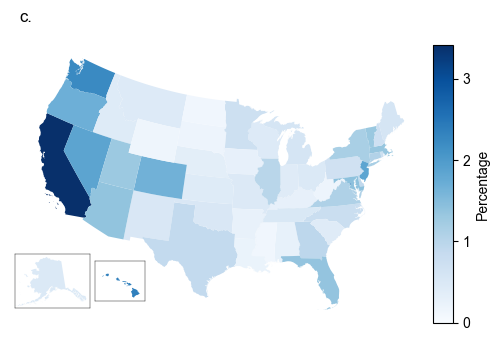

In [8]:
# Define colormap range
vmin = 0
vmax = gdf_state['share_EVs_inState_pct'].max()

# Set-up axes
fig, axs = plt.subplots(1, 1, figsize=(5, 4))
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Lower 48
lns = gdf_state.plot(column='share_EVs_inState_pct',
                     ax=axs, categorical=False, cmap='Blues',vmin=vmin, vmax=vmax,
                     legend=True, cax=cax, legend_kwds={'label':'Percentage', 'shrink':0.5})

axs.set_title('c.', loc='left', fontsize=12)
axs.set_axis_off()

cbar = axs.get_figure().axes[-1] 
cbar.set_yticks([0, 1, 2, 3])
cbar.set_yticklabels([0, 1, 2, 3])

# Add Alaska
akax = fig.add_axes([.02, 0.175, 0.15, 0.15])   
lns2 = gdf_state_alaska.plot(column='share_EVs_inState_pct',
                                                   ax=akax,
                                                   categorical=False,
                                                   cmap='Blues', vmin=vmin, vmax=vmax,
                                                   legend=False)
akax.set_xlim([0.5e6, 3.5e6])
akax.set_xticks([])
akax.set_yticks([])
for axis in ['top','bottom','left','right']:
    akax.spines[axis].set_linewidth(0.3)

# Add Hawaii
hiax = fig.add_axes([0.18, 0.2, 0.1, 0.1]) 
lns2 = gdf_state_hawaii.plot(column='share_EVs_inState_pct',
                                                   ax=hiax,
                                                   categorical=False,
                                                   cmap='Blues', vmin=vmin, vmax=vmax,
                                                   legend=False)
hiax.set_xlim([0.5e6, 3e6])
hiax.set_ylim([-1e6, 1e6])
hiax.set_xticks([])
hiax.set_yticks([])
for axis in ['top','bottom','left','right']:
    hiax.spines[axis].set_linewidth(0.3)

# Save
plt.tight_layout()
plt.savefig('Figures/figure1c_map_EVs_'+savedate+'.pdf', bbox_inches='tight')
plt.savefig('Figures/figure1c_map_EVs_'+savedate+'.png', bbox_inches='tight', dpi=1000)
plt.show()